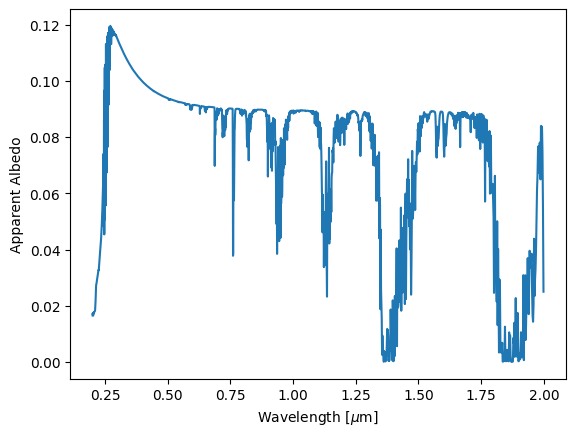

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_parquet("../data/modern/5-6.parquet")

index = np.random.randint(0, len(df))
wavelength = df.iloc[index]["WAVELENGTH"]
albedo = df.iloc[index]["ALBEDO"]

_, ax = plt.subplots()
ax.plot(wavelength, albedo)
ax.set(xlabel="Wavelength [$\mu$m]", ylabel="Apparent Albedo");

In [63]:
import numpy as np

planet_radius = np.random.uniform(0.3, 1.23)
pressure = 1013.25 * (planet_radius ** (3.168 + np.random.uniform(-0.232, 0.232)))
planet_mass = planet_radius ** (1 / (0.279 + np.random.uniform(-0.009, 0.009)))

planet_radius, pressure, planet_mass

(0.7419737463522514, 409.10656811459467, 0.3525492279974868)

In [61]:
import astropy.units as u
from astropy.constants import R_sun, L_sun, sigma_sb, G, M_earth, R_earth

In [64]:
gravity = G.value * (planet_mass * M_earth.value) / (planet_radius * R_earth.value) ** 2
escape_velocity = np.sqrt(2 * gravity * planet_radius * R_earth.value)
escape_velocity_km = escape_velocity / 1000
escape_velocity_km

7.706440249457478

In [ ]:
np.logspace(np.log10(scaled_pres), np.log10(1e-11), num=layers)

In [115]:
# Default HabEx Configuration Loading
with open("../geexhp/config/default_habex.config", "rb") as f:
    config = OrderedDict(msgpack.unpack(f, raw=False))

In [117]:
def calculate_luminosity(config: dict) -> float:
    """
    Calculate luminosity using the Stefan-Boltzmann Law to calculate luminosity.
    """
    star_radius = config['OBJECT-STAR-RADIUS']
    temperature = config['OBJECT-STAR-TEMPERATURE']
    return 4 * np.pi * (star_radius * R_sun.value) ** 2 * sigma_sb.value * temperature ** 4

def set_habitable_zone_distance(config: dict) -> None:
    """
    Calculates and sets the habitable zone distance based on the star's 
    luminosity and temperature.

    Notes
    -----
    Source: Habitable zones around main-sequence stars... 
    ([Kopparapu et al. (2014)](https://iopscience.iop.org/article/10.1088/2041-8205/787/2/L29/pdf)). 
    See Equation 4 and Table 1 from Kopparapu et al. (2013)
    """
    temp = config['OBJECT-STAR-TEMPERATURE'] - 5780
    luminosity_star = calculate_luminosity(config)

    # Recent Venus (lower limit)
    S_eff_odot = 1.776
    a, b, c, d = 2.136e-4, 2.533e-8, -1.332e-11, -3.097e-15
    S_eff_lower = S_eff_odot + a * temp + b * temp**2 + c * temp**3 + d * temp**4

    # Early Mars (upper limit)
    S_eff_odot = 0.32
    a, b, c, d = 5.547e-5, 1.526e-9, -2.874e-12, -5.011e-16
    S_eff_upper = S_eff_odot + a * temp + b * temp**2 + c * temp**3 + d * temp**4

    # Distance of the habitable zone
    lower_dist = np.sqrt((luminosity_star / L_sun.value) / S_eff_lower)
    upper_dist = np.sqrt((luminosity_star / L_sun.value) / S_eff_upper)
    config['OBJECT-STAR-DISTANCE'] = np.random.uniform(lower_dist, upper_dist)

def maintain_planetary_atmosphere(config: dict) -> None:
    """
    Simulates to find a planet size that can maintain an atmosphere. 
    References are included for each scientific principle used.
    """
    semi_major_axis = config['OBJECT-STAR-DISTANCE']
    star_luminosity = calculate_luminosity(config)

    has_atmosphere = False

    while not has_atmosphere:
        # Define the planet's radius in Earth radii; targeting terrestrial planets 
        # up to about 1.23 Earth radii. Based on findings from "A rocky exoplanet classification method 
        # and its application to calculating surface pressure and surface temperature"
        # Reference: https://arxiv.org/abs/2301.03348
        planet_radius = np.random.uniform(0.3, 1.23)

        # # Calculate planet mass based on planet radius using the relationship
        # derived from Equation (2) of the paper "A rocky exoplanet classification method 
        # and its application to calculating surface pressure and surface temperature" 
        # by McIntyre et al. (2023)
        planet_mass = planet_radius ** (1 / (0.279 + np.random.uniform(-0.009, 0.009)))
        
        # Calculate planetary gravity (g = GM/r²) in m/s² using the mass and radius 
        # estimates.
        gravity = G.value * (planet_mass * M_earth.value) / (planet_radius * R_earth.value) ** 2

        # Calculate escape velocity from the planet's surface in m/s
        escape_velocity = np.sqrt(2 * gravity * planet_radius * R_earth.value)

        # Compute the XUV-driven atmospheric escape, considering the star-planet 
        # distance and stellar luminosity. Reference for insolation calculations: 
        # Zahnle and Catling (2017), particularly their Equation (27)
        # https://arxiv.org/pdf/1702.03386
        insolation_xuv = (1 ** 2 / semi_major_axis ** 2) * (star_luminosity / L_sun.value) ** 0.4

        # Estimate the critical insolation for atmospheric retention based on escape 
        # velocity, using an empirically derived relationship from Zahnle and 
        # Catling (2017), with approximation from graph analysis.
        # See equation (7) by McIntyre et al. (2023)
        cosmic_shoreline = (5 * 1e-16) * (escape_velocity) ** 4

        # Check if the current insolation is less than the calculated critical 
        # insolation for the planet.
        if insolation_xuv < cosmic_shoreline:
            has_atmosphere = True

    # Once a suitable planet is found, set its pressure (in mbar), diameter and surface gravity 
    # in the dictionary.
    # According to the paper "A rocky exoplanet classification method and its application to calculating 
    # surface pressure and surface temperature" by McIntyre et al. (2023), Equation (3)
    config["ATMOSPHERE-PRESSURE"] = 1013.25 * (planet_radius ** (3.168 + np.random.uniform(-0.232, 0.232)))
    
    config['OBJECT-DIAMETER'] = 2 * planet_radius * R_earth.to(u.km).value 
    config['OBJECT-GRAVITY'] = gravity 

In [140]:
calculate_luminosity(config)
set_habitable_zone_distance(config)
maintain_planetary_atmosphere(config)

In [141]:
np.logspace(np.log10(config["ATMOSPHERE-PRESSURE"] / 1000), np.log10(1e-11), num=60)

array([1.19229400e+00, 7.73834427e-01, 5.02241662e-01, 3.25969844e-01,
       2.11564168e-01, 1.37311466e-01, 8.91192435e-02, 5.78410516e-02,
       3.75405706e-02, 2.43649519e-02, 1.58135817e-02, 1.02634870e-02,
       6.66130968e-03, 4.32338900e-03, 2.80600863e-03, 1.82118343e-03,
       1.18200246e-03, 7.67154909e-04, 4.97906456e-04, 3.23156165e-04,
       2.09738006e-04, 1.36126232e-04, 8.83499916e-05, 5.73417841e-05,
       3.72165311e-05, 2.41546406e-05, 1.56770834e-05, 1.01748955e-05,
       6.60381116e-06, 4.28607074e-06, 2.78178796e-06, 1.80546350e-06,
       1.17179975e-06, 7.60533047e-07, 4.93608670e-07, 3.20366774e-07,
       2.07927608e-07, 1.34951229e-07, 8.75873798e-08, 5.68468263e-08,
       3.68952886e-08, 2.39461446e-08, 1.55417633e-08, 1.00870687e-08,
       6.54680895e-09, 4.24907460e-09, 2.75777636e-09, 1.78987925e-09,
       1.16168511e-09, 7.53968343e-10, 4.89347981e-10, 3.17601459e-10,
       2.06132836e-10, 1.33786369e-10, 8.68313505e-11, 5.63561407e-11,
      

In [299]:
# Generate random molecule concentrations
molecules = ['H2O', 'CO2', 'CH4', 'O2', 'NH3', 'HCN', 'PH3', 'SO2', 'H2S']

molecular_weights = {
        'H2O': 18.01528,  
        'CO2': 44.0095,   
        'CH4': 16.0425,   
        'O2': 31.99880,   
        'NH3': 17.03052,  
        'HCN': 27.0253,   
        'PH3': 33.99758,  
        'SO2': 64.0638,   
        'H2S': 34.0809   
    }

# Calculate random values for each molecule
sample = {}
for molecule in molecules:
    sample[molecule] = np.random.lognormal(-13, 1)
display(sample)

total_concentration = sum(sample.values())
normalized_sample = {molecule: value / total_concentration for molecule, value in sample.items()}
layer_concentrations = {molecule: np.full(60, concentration) for molecule, concentration in normalized_sample.items()}

print(total_concentration)
display(normalized_sample)
print(sum(normalized_sample.values()))

sum(normalized_sample[molecule] * molecular_weights[molecule] for molecule in normalized_sample)

{'H2O': 3.062819094531087e-06,
 'CO2': 1.2479869913585868e-06,
 'CH4': 2.5003626744235323e-06,
 'O2': 4.724151727625504e-06,
 'NH3': 3.854672773868176e-06,
 'HCN': 1.7287399577927628e-06,
 'PH3': 4.754821580616726e-06,
 'SO2': 9.201714656274038e-07,
 'H2S': 1.04065644738999e-05}

3.3200290739743675e-05


{'H2O': 0.09225277930667704,
 'CO2': 0.037589640438438585,
 'CH4': 0.0753114692285022,
 'O2': 0.1422924806489805,
 'NH3': 0.1161035848777611,
 'HCN': 0.05207002466768487,
 'PH3': 0.14321626331195905,
 'SO2': 0.0277157652877382,
 'H2S': 0.31344799223225855}

1.0


29.78931955969467